# Временные ряды
## Домашнее задание №2

<pre>
ФИО: Никифоров Владимир
</pre>

#### Взять из прошлого домашнего задания ряд (в двух вариантах - стационарный и нет) и приблизить оба эти варианта моделями из класса MA. Оценить качество и прислать соображения почему была выбрана та или иная модель

Взят ряд international-airline-passengers2.csv как нестационарный, с выраженным изменением дисперсии и сезонностью.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline

/home/truename/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


/home/truename/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


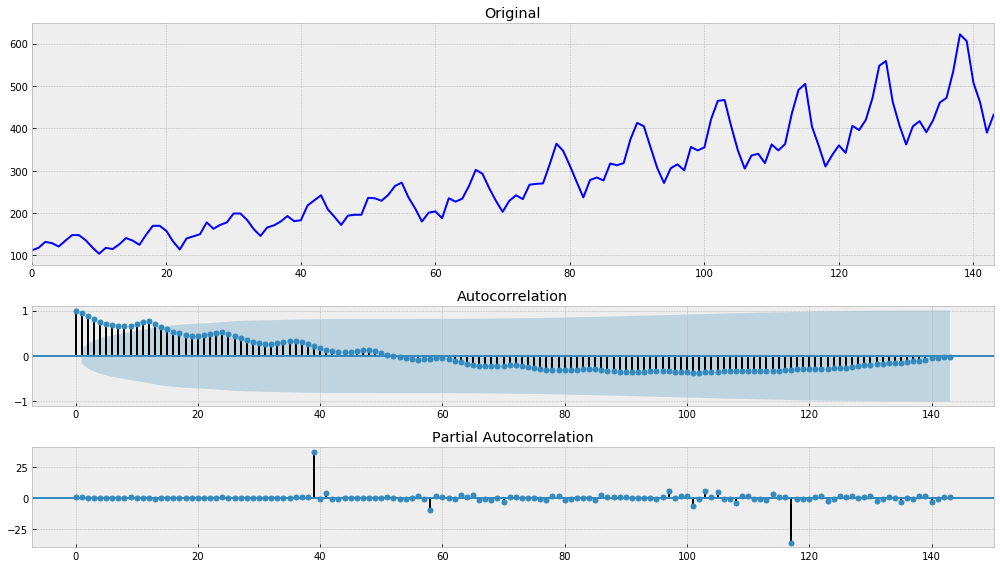

In [2]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    return dftest[1], dftest[2]

def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    p_val, lag = test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
        plt.show()
    return p_val, lag

df = pd.read_csv('../data/international-airline-passengers2.csv').dropna()
df.head()
original_series = df.iloc[:,1]
p_val, lag = tsplot(original_series)

Ряд характеризуется ростом во времени дисперсии и сезонностью.

Применим преобразование Бокса-Кокса, дифференцирование и избавимся от сезонности:

Results of Dickey-Fuller Test:
Test Statistic                  -3.387671
p-value                          0.011386
#Lags Used                      11.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


/home/truename/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


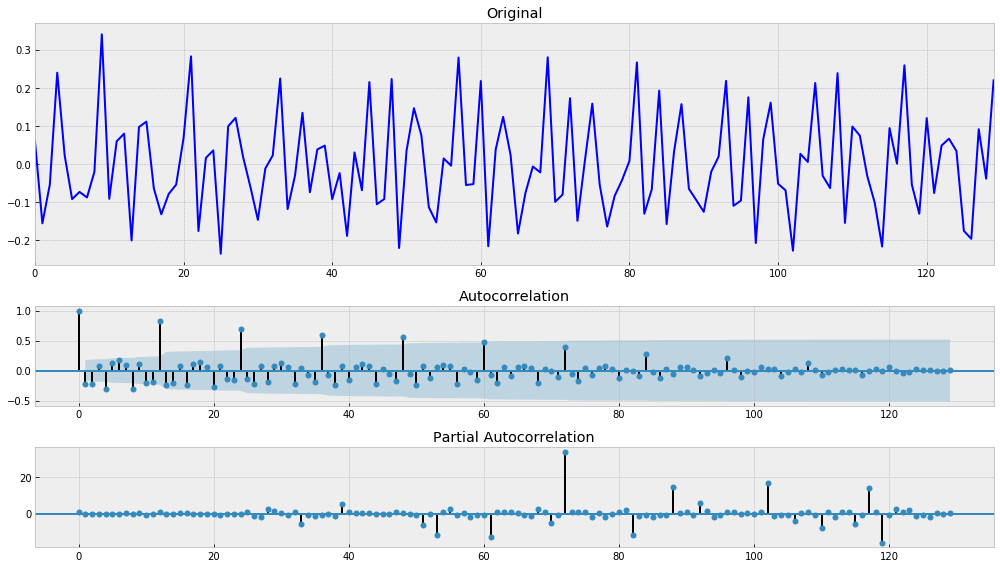

In [3]:
series = boxcox(original_series, 0)
series = series[1:] - series[:-1]
series = series[lag:] - series[:-lag]
p_val, lag = tsplot(series)

Итак, попробуем получить аналогичные ряды с помощью MA.

In [4]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

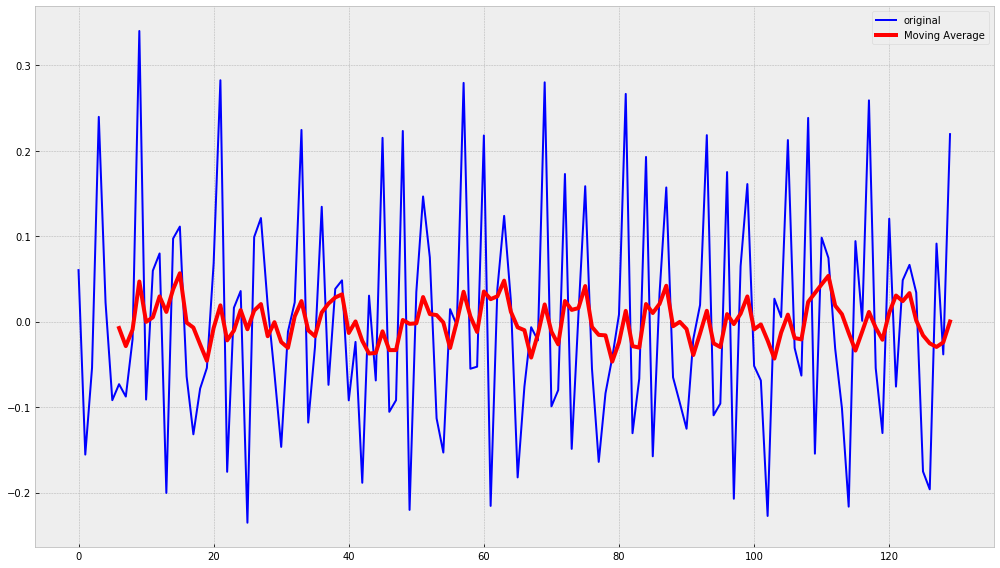

In [5]:
ser = moving_average(series, 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    plt.plot(ser, color='red', linewidth='4', label='Moving Average')
    plt.tight_layout()
    plt.legend()

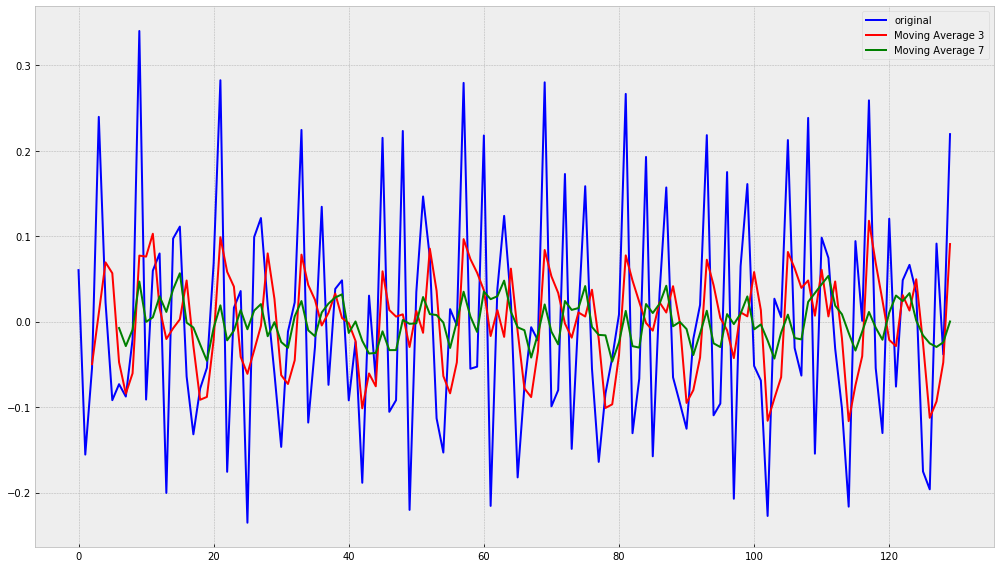

In [6]:
windows = [3,7]
colors = ['red', 'green']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    for i in range(len(windows)):
        ser = moving_average(series, windows[i])
        plt.plot(ser, color=colors[i], linewidth='2', label='Moving Average {}'.format(windows[i]))
    plt.tight_layout()
    plt.legend()

Применим двойное сглаживание, тройное не требуется, т.к. ряд очищен от сезонности.

In [7]:
def double_ema(series, alpha, beta, n_preds=0):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for i in range(1, len(series)+n_preds):
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            last_level, level = level, alpha*value + (1-alpha)*(level+trend)
            trend = beta*(level-last_level) + (1-beta)*trend
            result.append(level + m*trend)
        else:
            value = series[i]
            last_level, level = level, alpha*value + (1-alpha)*(level+trend)
            trend = beta*(level-last_level) + (1-beta)*trend
            result.append(level+trend)

    return pd.Series(result)

In [8]:
def plot_dema(series, alpha, beta, ser_to_plot=series, n_preds=0):
    dema = double_ema(series, alpha, beta, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(series, color='blue',label='original')
        plt.plot(dema, color='red', linewidth='2', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.tight_layout()
        plt.legend()

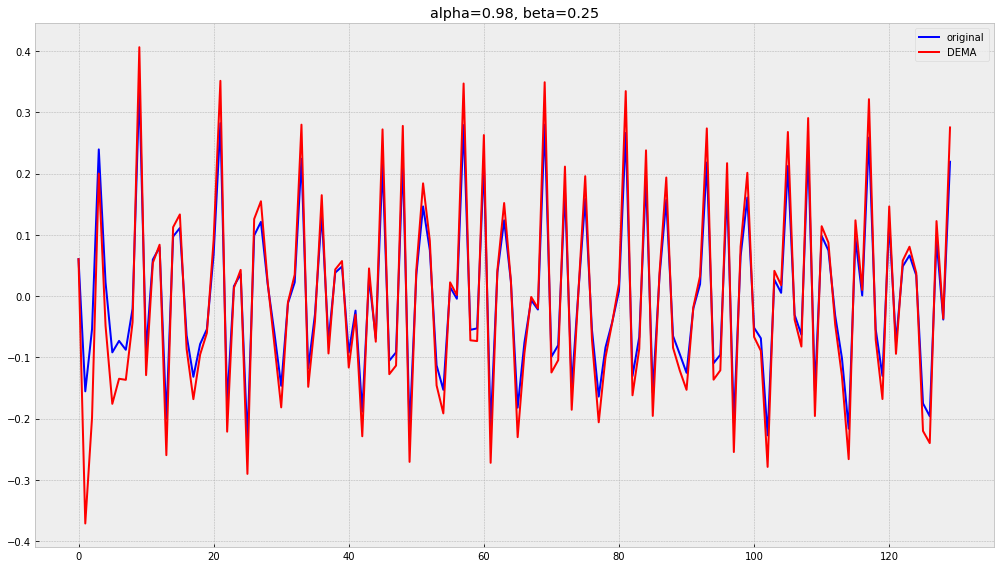

In [9]:
plot_dema(series, 0.98, 0.25)

Попробуем подобрать оптимальные параметры 

In [10]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [11]:
train, test, val = series[:60], series[60:70], series[70:]

In [12]:
def mse(X):
    alpha, beta = X
    result = double_ema(train, alpha, beta, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [13]:
opt = minimize(mse, x0=[0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1)))

In [14]:
alpha_opt, beta_opt = opt.x
print(opt)

      fun: 0.03040840658772729
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.20058373e-03, -5.32560107e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 60
      nit: 19
   status: 0
  success: True
        x: array([1.        , 0.10718657])


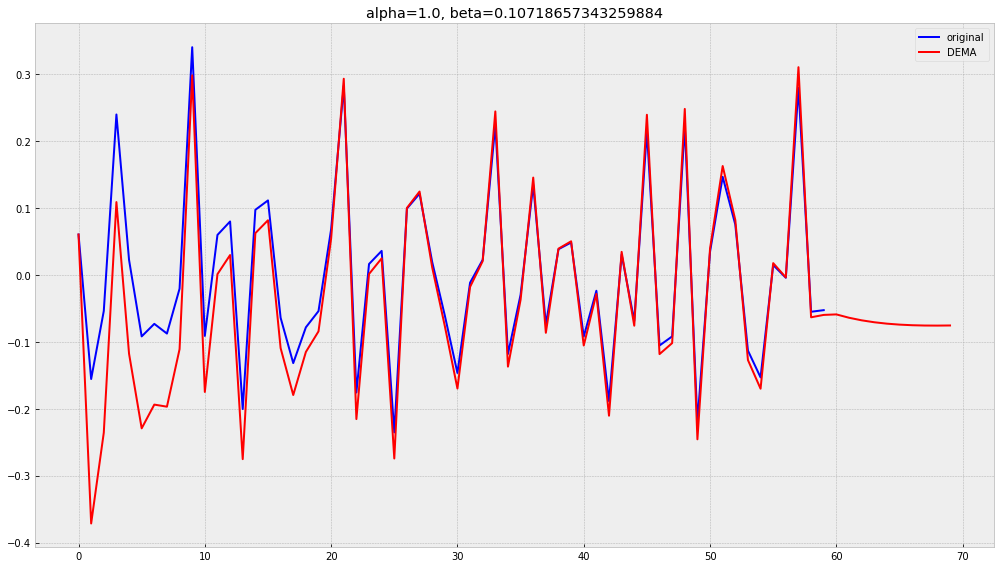

In [15]:
plot_dema(series=train, alpha=alpha_opt, beta=beta_opt, ser_to_plot=series[:70], n_preds=len(test))

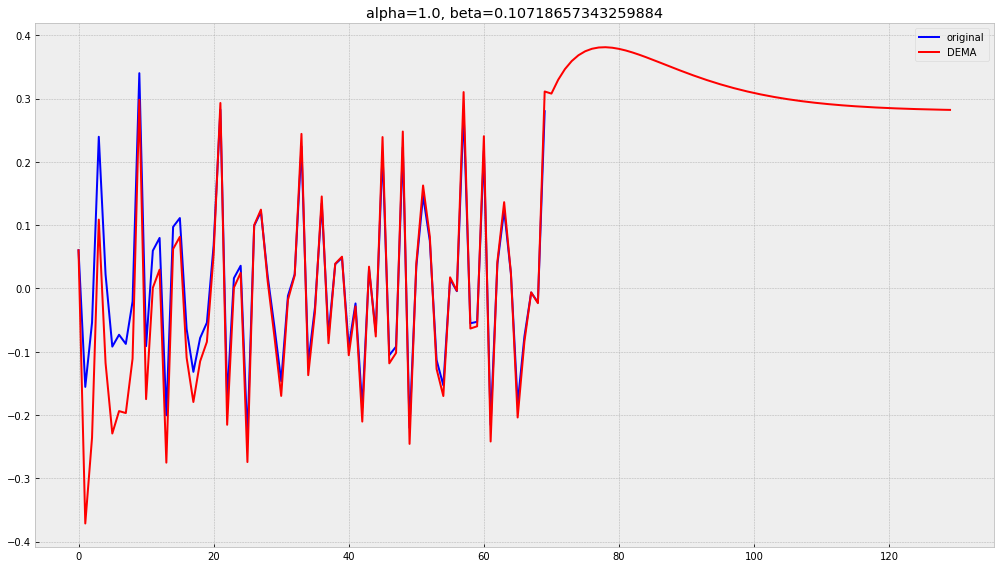

In [16]:
plot_dema(series=series[:70], alpha=alpha_opt, beta=beta_opt, ser_to_plot=series, n_preds=len(val))

Какой прелестный прогноз, хотя сам ряд повторяется хорошо)

### Теперь рассмотрим оригинальный ряд

Ввиду наличия сезонности у оригинального ряда применим тройное сглаживание Хольта-Винтерса

In [17]:
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [18]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [19]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [20]:
def plot_tema(alpha, beta, gamma, ser=original_series, ser_to_plot=original_series, n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.tight_layout()
        plt.legend()

In [21]:
series = original_series

In [22]:
train, test, val = series[:60], series[60:70], series[70:]

In [23]:
def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [24]:
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [25]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 175.55257598803922
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-167.37660644,   -0.46684363,   10.66482866])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 872
      nit: 133
   status: 0
  success: True
        x: array([0.00250475, 0.93666316, 0.        ])


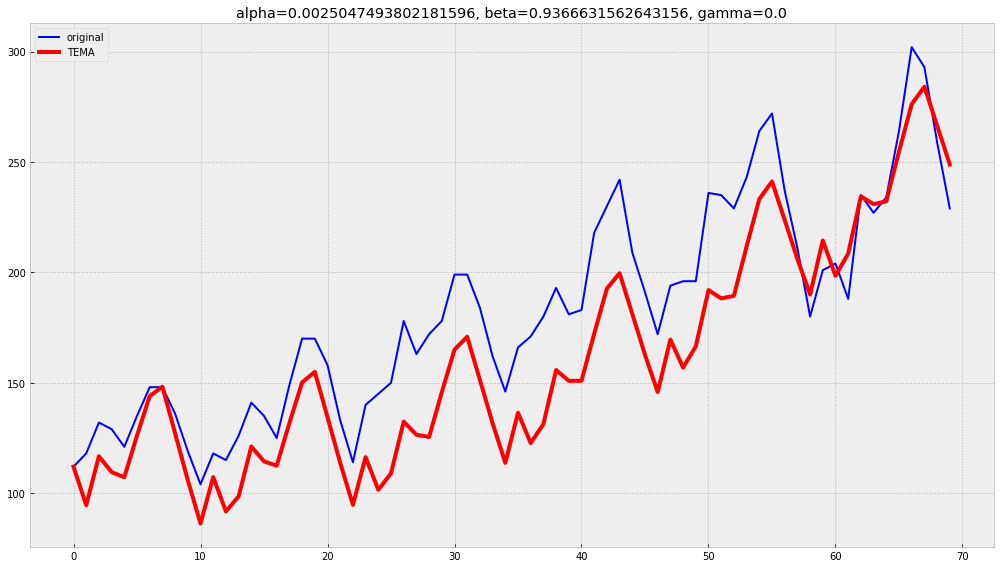

In [26]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series[:70], n_preds=len(test))

Видно, что в сезонность попадаем, но не попадаем в растущий уровень ряда

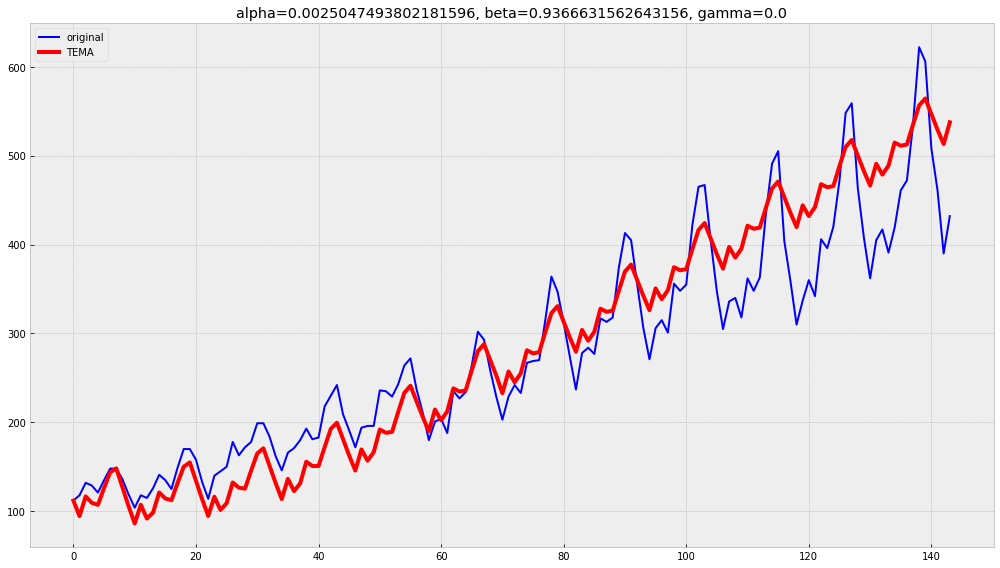

In [27]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=series[:70], ser_to_plot=series, n_preds=len(val))

Попадаем в сезонность, тренд, но не попадаем в растущую амплитуду (дисперсию) ряда.

Подбор параметров вручную:

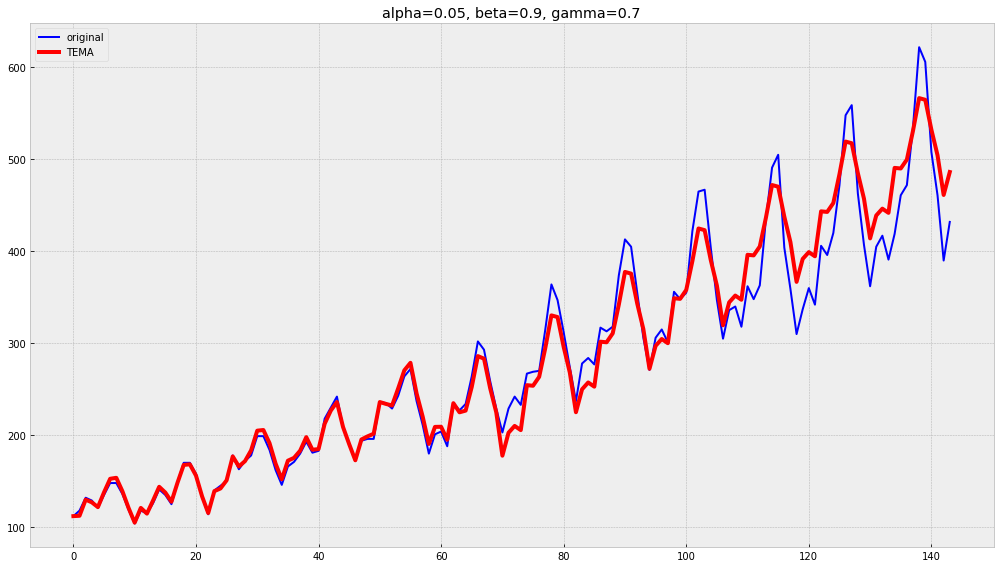

In [28]:
plot_tema(0.05, 0.9, 0.7, ser=series[:70], ser_to_plot=series, n_preds=len(val))

Попадание стало лучше во всем, но не идеально.